# Deep Colorization
### Deep learning final project for conversion of gray scale images to rgb
### Contributors: Bhumi Bhanushali, Avinash Hemaeshwara Raju, Kathan Nilesh Mehta, Atulay Ravishankar

### Download Dataset

In [3]:
# wget -N images.cocodataset.org/zips/train2017.zip
# wget -N images.cocodataset.org/zips/val2017.zip
# wget -N images.cocodataset.org/zips/test2017.zip
# pip3 install tensorboard
# tensorboard --logdir=runs

### Import Modules

In [4]:
import os
import time
import numpy as np 
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
import cv2
from matplotlib import pyplot as plt

### Configuration

In [5]:
class Configuration:
    model_file_name = 'checkpoint.pt'
    load_model_to_train = False
    load_model_to_test = False
    device = "cuda" if torch.cuda.is_available() else "cpu"
    point_batches = 10

### Hyper Parameters

In [6]:
class HyperParameters:
    epochs = 1
    batch_size = 64
    learning_rate = 0.001
    num_workers = 8
    learning_rate_decay = 0.5

In [7]:
config = Configuration()
hparams = HyperParameters()
print('Device:',config.device)

Device: cuda


### Custom Dataloader

In [8]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, process_type):
        self.root_dir = root_dir
        self.files = [f for f in os.listdir(root_dir)]
        self.process_type = process_type
        print('File[0]:',self.files[0],'| Total Files:', len(self.files), '| Process:',self.process_type,)

    def __len__(self):
        return 128#len(self.files)

    def __getitem__(self, index):
        try:
            #*** Read the image from file ***
            self.rgb = cv2.imread(os.path.join(self.root_dir,self.files[index])) 
            
            #*** Resize the color image to pass to encoder ***
            rgb_encoder = cv2.resize(self.rgb, (224, 224))
            
            #*** Resize the color image to pass to decoder ***
            rgb_inception = cv2.resize(self.rgb, (300, 300))
            
            #*** Convert the encoder color image to lab space ***
            self.lab_encoder = cv2.cvtColor(rgb_encoder,cv2.COLOR_RGB2Lab) 
            
            #*** Extract the l-channel of the lab image ***
            l_encoder = self.lab_encoder[:,:,0]
            
            #*** Repeat the encoder l-channel image in 3 channels ***
            l_encoder = np.stack((l_encoder,)*3,axis = -1)
            
            #*** Convert the 3-channel l encoder image to torch tensor ***
            l_encoder = torchvision.transforms.ToTensor()(l_encoder)
            
            #*** Convert the ab-channels of encoder image to torch tensor for loss calculation ***
            ab_encoder = self.lab_encoder[:,:,1:3]
            ab_encoder = torchvision.transforms.ToTensor()(ab_encoder)
            
            #*** Convert the inception color image to lab space ***
            self.lab_inception = cv2.cvtColor(rgb_inception,cv2.COLOR_RGB2Lab)
            
            #*** Extract the l-channel of inception lab image and stack it in 3 channels *** 
            l_inception = self.lab_inception[:,:,0]
            l_inception = np.stack((l_inception,)*3,axis = -1)
            
            #*** Convert the inception l-image to torch Tensor ***
            l_inception = torchvision.transforms.ToTensor()(l_inception)

            #*** return images to data-loader ***
            return l_encoder, ab_encoder, l_inception, torchvision.transforms.ToTensor()(rgb_encoder)
        
        except Exception as e:
            print('Exception at ',self.files[index], e)
            return torch.tensor(-1), torch.tensor(-1), torch.tensor(-1), torch.tensor(-1)

    def show_rgb(self, index):
        self.__getitem__(index)
        print("RGB image size:", self.rgb.shape)        
        plt.imshow(self.rgb)
        plt.show()

    def show_lab_encoder(self, index):
        self.__getitem__(index)
        print("Encoder Lab image size:", self.lab_encoder.shape)
        plt.imshow(self.lab_encoder)
        plt.show()

    def show_lab_inception(self, index):
        self.__getitem__(index)
        print("Inception Lab image size:", self.lab_inception.shape)
        plt.imshow(self.lab_inception)
        plt.show()
    
    def show_other_images(self, index):
        a,b,c,d = self.__getitem__(index)
        print("Encoder l channel image size:",a.shape)
        plt.imshow(a.detach().numpy().transpose(1,2,0))
        plt.show()
        print("Encoder ab channel image size:",b.shape)
        plt.imshow(b.detach().numpy().transpose(1,2,0)[:,:,0])
        plt.show()
        plt.imshow(b.detach().numpy().transpose(1,2,0)[:,:,1])
        plt.show()
        print("Inception l channel image size:",c.shape)
        plt.imshow(c.detach().numpy().transpose(1,2,0))
        plt.show()
        print("Color resized image size:",d.shape)
        plt.imshow(d.detach().numpy().transpose(1,2,0))
        plt.show()

In [9]:
train_dataset = CustomDataset('data/train','train')

File[0]: 000000398183.jpg | Total Files: 73731 | Process: train


RGB image size: (427, 640, 3)


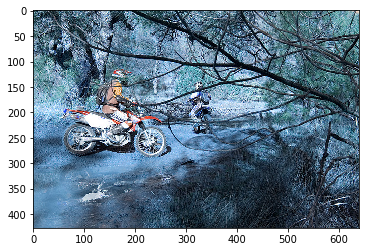

Encoder Lab image size: (224, 224, 3)


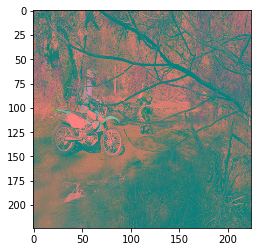

Inception Lab image size: (300, 300, 3)


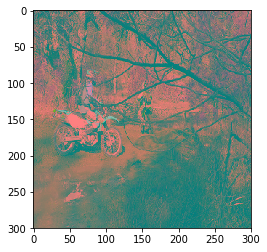

Encoder l channel image size: torch.Size([3, 224, 224])


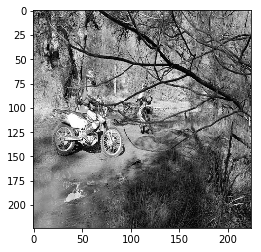

Encoder ab channel image size: torch.Size([2, 224, 224])


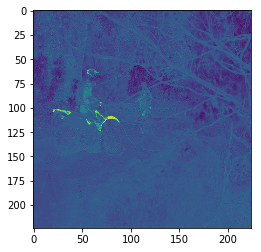

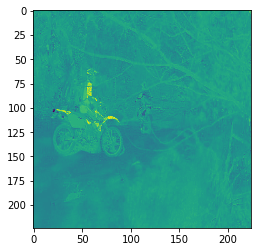

Inception l channel image size: torch.Size([3, 300, 300])


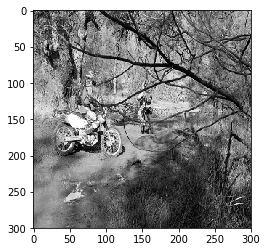

Color resized image size: torch.Size([3, 224, 224])


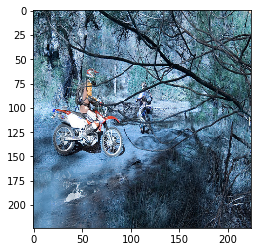

In [10]:
train_dataset.show_rgb(0)
train_dataset.show_lab_encoder(0)
train_dataset.show_lab_inception(0)
train_dataset.show_other_images(0)

### Encoder

In [11]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        self.model = self.model.float()
        return self.model(x.float())

### Fusion Layer

In [12]:
class FusionLayer(nn.Module):
    def __init__(self):
        super(FusionLayer,self).__init__()

    def forward(self, inputs, mask=None):
        ip, emb = inputs
        emb = torch.stack([torch.stack([emb],dim=2)],dim=3)
        emb = emb.repeat(1,1,ip.shape[2],ip.shape[3])
        fusion = torch.cat((ip,emb),1)
        return fusion

### Decoder

In [13]:
class Decoder(nn.Module):
    def __init__(self, input_depth):
        super(Decoder,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=input_depth, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2.0),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2.0),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=2, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.Upsample(scale_factor=2.0),
        )

    def forward(self, x):
        return self.model(x)

### Network Definition

In [14]:
class Colorization(nn.Module):
    def __init__(self, depth_after_fusion):
        super(Colorization,self).__init__()
        self.encoder = Encoder()
        self.fusion = FusionLayer()
        self.after_fusion = nn.Conv2d(in_channels=1256, out_channels=depth_after_fusion,kernel_size=1, stride=1,padding=0)
        self.decoder = Decoder(depth_after_fusion)

    def forward(self, img_l, img_emb):
        img_enc = self.encoder(img_l)
        fusion = self.fusion([img_enc, img_emb])
        fusion = self.after_fusion(fusion)
        return self.decoder(fusion)

def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight.data)

### Architecture Pipeline

In [15]:
if config.load_model_to_train or config.load_model_to_test:
    checkpoint = torch.load(config.model_file_name,map_location=torch.device(config.device))
    model = checkpoint['model']
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(config.device) 
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print('Loaded pretrain model | Previous train loss:',checkpoint['train_loss'], '| Previous validation loss:',checkpoint['val_loss'])
else:
    model = Colorization(256).to(config.device) 
    model.apply(init_weights)
    optimizer = torch.optim.Adam(model.parameters(),lr=hparams.learning_rate, weight_decay=1e-6)

inception_model = models.inception_v3(pretrained=True).float().to(config.device)
inception_model = inception_model.float()
inception_model.eval()
loss_criterion = torch.nn.MSELoss(reduction='mean').to(config.device)
milestone_list  = list(range(0,hparams.epochs,2))
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestone_list, gamma=hparams.learning_rate_decay)
writer = SummaryWriter()

### Data Loaders

In [16]:
if not config.load_model_to_test:
    train_dataset = CustomDataset('data/train','train')
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=hparams.batch_size, shuffle=True, num_workers=hparams.num_workers)
    

    validataion_dataset = CustomDataset('data/validation','validation')
    validation_dataloader = torch.utils.data.DataLoader(validataion_dataset, batch_size=hparams.batch_size, shuffle=False, num_workers=hparams.num_workers)
    
    print('Train:',len(train_dataloader), '| Total Images:',len(train_dataloader)*hparams.batch_size)
    print('Valid:',len(validation_dataloader), '| Total Images:',len(validation_dataloader)*hparams.batch_size)

File[0]: 000000398183.jpg | Total Files: 73731 | Process: train
File[0]: 000000521956.jpg | Total Files: 5000 | Process: validation
Train: 2 | Total Images: 128
Valid: 2 | Total Images: 128


### Training & Validation Pipeline

In [17]:
if not config.load_model_to_test:
    for epoch in range(hparams.epochs):
        print('Starting epoch:',epoch+1)

        #*** Training step ***
        loop_start = time.time()
        avg_loss = 0.0
        batch_loss = 0.0
        main_start = time.time()
        model.train()

        for idx,(img_l_encoder, img_ab_encoder, img_l_inception, img_rgb) in enumerate(train_dataloader):
            #*** Skip bad data ***
            if not img_l_encoder.ndim:
                continue

            #*** Move data to GPU if available ***
            img_l_encoder = img_l_encoder.to(config.device)
            img_ab_encoder = img_ab_encoder.to(config.device)
            img_l_inception = img_l_inception.to(config.device)

            #*** Initialize Optimizer ***
            optimizer.zero_grad()

            #*** Forward Propagation ***
            img_embs = inception_model(img_l_inception.float())
            output_ab = model(img_l_encoder,img_embs)

            #*** Back propogation ***
            loss = loss_criterion(output_ab, img_ab_encoder.float())
            loss.backward()

            #*** Weight Update ****
            optimizer.step()

            #*** Reduce Learning Rate ***
            scheduler.step()

            #*** Loss Calculation ***
            avg_loss += loss.item()
            batch_loss += loss.item()

            #*** Print stats after every point_batches ***
            if idx%config.point_batches==0: 
                loop_end = time.time()   
                print('Batch:',idx, '| Processing time for',config.point_batches,':',loop_end-loop_start,\
                     '| Batch Loss:', batch_loss/config.point_batches)
                loop_start = time.time()
                batch_loss = 0.0

        #*** Print Training Data Stats ***
        train_loss = avg_loss/len(train_dataloader)*hparams.batch_size
        writer.add_scalar('Loss/train', train_loss, epoch)
        print('Training Loss:',train_loss,'| Processed in ',time.time()-main_start,'s')

        #*** Validation Step ***       
        avg_loss = 0.0
        loop_start = time.time()
        #*** Intialize Model to Eval Mode for validation ***
        model.eval()
        for idx,(img_l_encoder, img_ab_encoder, img_l_inception, img_rgb) in enumerate(validation_dataloader):
            #*** Skip bad data ***
            if not img_l_encoder.ndim:
                continue

            #*** Move data to GPU if available ***
            img_l_encoder = img_l_encoder.to(config.device)
            img_ab_encoder = img_ab_encoder.to(config.device)
            img_l_inception = img_l_inception.to(config.device)


            #*** Forward Propagation ***
            img_embs = inception_model(img_l_inception.float())
            output_ab = model(img_l_encoder,img_embs)

            #*** Loss Calculation ***
            loss = loss_criterion(output_ab, img_ab_encoder.float())
            avg_loss += loss.item()

        val_loss = avg_loss/len(validation_dataloader)*hparams.batch_size
        writer.add_scalar('Loss/validation', val_loss, epoch)
        print('Validation Loss:', val_loss,'| Processed in ',time.time()-loop_start,'s')

        #*** Save the Model to disk ***
        checkpoint = {'model': model,'model_state_dict': model.state_dict(),\
                      'optimizer' : optimizer,'optimizer_state_dict' : optimizer.state_dict(),\
                      'train_loss':train_loss, 'val_loss':val_loss}
        torch.save(checkpoint, config.model_file_name)
        print("Model saved at:",os.getcwd(),'/',config.model_file_name)

Starting epoch: 1
Batch: 0 | Processing time for 10 : 2.897130250930786 | Batch Loss: 0.050765770673751834
Training Loss: 19.79012131690979 | Processed in  4.319279670715332 s


RuntimeError: CUDA out of memory. Tried to allocate 56.00 MiB (GPU 0; 14.73 GiB total capacity; 13.66 GiB already allocated; 55.88 MiB free; 315.16 MiB cached)

### Inference

In [ ]:
test_dataset = CustomDataset('data/test','test')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=16)
print('Test: ',len(test_dataloader), '| Total Image:',len(test_dataloader))

##### Convert Tensor Image -> Numpy Image -> Color  Image -> Tensor Image

In [ ]:
def concatente_and_colorize(im_lab, img_ab):
    # Assumption is that im_lab is of size [1,3,224,224]
    np_img = im_lab[0].cpu().detach().numpy().transpose(1,2,0)
    lab = np.empty([*np_img.shape[0:2], 3],dtype=np.float32)
    lab[:, :, 0] = np.squeeze(((np_img + 1) * 50))
    lab[:, :, 1:] = img_ab[0].cpu().detach().numpy().transpose(1,2,0) * 127
    np_img = cv2.cvtColor(lab,cv2.COLOR_Lab2RGB) 
    color_im = torch.stack([torchvision.transforms.ToTensor()(np_img)],dim=0)
    return color_im

In [ ]:
def colorize(im_lab):
    # Assumption is that im_lab is of size [1,3,224,224]
    np_img = im_lab[0].detach().numpy().transpose(1,2,0)
    np_img = color.lab2rgb(np_img)
    color_im = torch.stack([torchvision.transforms.ToTensor()(np_img)],dim=0)
    return color_im

In [ ]:
#*** Inference Step ***
avg_loss = 0.0
loop_start = time.time()
for idx,(img_l_encoder, img_ab_encoder, img_l_inception, img_rgb) in enumerate(test_dataloader):
        #*** Skip bad data ***
        if not img_l_encoder.ndim:
            continue
            
        #*** Move data to GPU if available ***
        img_l_encoder = img_l_encoder.to(config.device)
        img_ab_encoder = img_ab_encoder.to(config.device)
        img_l_inception = img_l_inception.to(config.device)
        
        #*** Intialize Model to Eval Mode ***
        model.eval()
        
        #*** Forward Propagation ***
        img_embs = inception_model(img_l_inception.float())
        output_ab = model(img_l_encoder,img_embs)
        
        #*** Adding l channel to ab channels ***
        img_lab = concatente_and_colorize(torch.stack([img_l_encoder[:,0,:,:]],dim=1),output_ab)
        
        #*** Plotting in jupyter notebook ***
        #plt.imshow(img_lab.detach().numpy()[0].transpose(1,2,0))
        #plt.show()
        
        #*** Printing to Tensor Board ***
        grid = torchvision.utils.make_grid(img_lab)
        writer.add_image('Output Lab Images', grid, 0)
        
        #*** Loss Calculation ***
        loss = loss_criterion(output_ab, img_ab_encoder.float())
        avg_loss += loss.item()
        
test_loss = avg_loss/len(test_dataloader)
writer.add_scalar('Loss/test', test_loss, epoch)
print('Test Loss:',avg_loss/len(test_dataloader),'| Processed in ',time.time()-loop_start,'s')

In [ ]:
writer.close()